In [2]:
import gymnasium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import random

from tqdm import tqdm
import numpy as np
import scipy.spatial
import os
import tarfile
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## PLAN for ideas

**Code building**
* create dataset 

**Uncertainty Quantification**
* quantify where current dynamics models show uncertainty and whether it matches with training data

**Evaluation review**
* check whether unsuccessful eval trajectories match with uncertainty from dynamics models 


## Code building
### Create dataset simple

Need to convert implementation from old gym to new gymnasium. 
+ have more control over exactly which data is created this is essential for offline RL setting 


In [3]:

env = gymnasium.make('PointMaze_Large-v3')
state = env.reset()[0]

states = []
actions = []
next_states = []
rewards_list = []
terminated_list = []


for _ in range(1000):
    action = env.action_space.sample()
    
    next_state, reward, terminated, truncated, info = env.step(action)
        
    states.append(state)
    actions.append(action)
    next_states.append(next_state)
    rewards_list.append(reward)
    terminated_list.append(terminated)
    
    state = next_state
    
    if terminated:
        state = env.reset()

states = np.array(states)
actions = np.array(actions)
next_states = np.array(next_states)
rewards_list = np.array(rewards_list)
terminated_list = np.array(terminated_list)



Find a way to sample from the 0 spaces with replacement at each env reset

In [4]:
SEED = 42

Mazes = {
    'PointMaze_UMaze-v3': [[1, 1, 1, 1, 1],
        [1, 0, 0, 0, 1],
        [1, 1, 1, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 1, 1, 1, 1]]
}

def find_zero_positions(maze):
    """
    Find the positions of zeros in a maze.

    Parameters:
    maze (list of lists): The maze to search.

    Returns:
    list of tuples: Positions of zeros in the maze.
    """
    zero_positions = [(i, j) for i, row in enumerate(maze) for j, value in enumerate(row) if value == 0]
    return zero_positions

find_zero_positions(Mazes['PointMaze_UMaze-v3'])

[(1, 1), (1, 2), (1, 3), (2, 3), (3, 1), (3, 2), (3, 3)]

#### Now convert this to data class to integrate the rest

In [5]:
class Offline_data_creator(Dataset):
    def __init__(self, env_name='PointMaze_UMaze-v3', n_pos_reward_traj=10, max_episode_steps = 1000,  normalise_data = True, video_path = '', capture_video= False, seed = None):
        self.device = device  
        self.seed = seed
        self.n_pos_reward_traj = n_pos_reward_traj
        self.capture_video = capture_video
        self.video_path = video_path
        self.env_name = env_name
        self.max_episode_steps = max_episode_steps
        self.normalise_data = normalise_data
        

        render_mode = "rgb_array" if capture_video else "human"
        self.base_env = gymnasium.make(env_name, 
                                       render_mode=render_mode, 
                                       max_episode_steps=max_episode_steps,
                                       continuing_task = False,
                                       reset_target = False)
        
        
        self.env = self.wrap_env(video_path)
    
        if self.seed is not None:
            self.env.action_space.seed(self.seed)

        
        zero_positions = find_zero_positions(Mazes[env_name])
        #self.fixed_goal_cell = np.array(random.choice(zero_positions))
        self.fixed_goal_cell = np.array([2, 3])
        exclude_positions = [np.array([3, 1]), np.array([3, 2]), np.array([3, 3]), self.fixed_goal_cell]
        self.remaining_positions = np.array([pos for pos in zero_positions
                                 if not any(np.array_equal(pos, exc) for exc in exclude_positions)])
    
    def wrap_env(self, video_path):
        if self.capture_video:
            return RecordVideo(self.base_env, video_folder=f"videos/{video_path}")
        else:
            return self.base_env
        
    def create_dataset(self):
        
        states, actions, next_states, terminated_flags, rewards = [], [], [], [], []
        pos_rewards_count = 0

        while pos_rewards_count < self.n_pos_reward_traj :

            options = {
                'goal_cell': self.fixed_goal_cell,
                'reset_cell': random.choice(self.remaining_positions)
            }
            print('goal_cell', self.fixed_goal_cell)
            print('reset cell', options['reset_cell'])

            state = self.env.reset(options=options)[0]['observation']

            print('state', state)

            for _ in range(self.max_episode_steps):
                action = self.env.action_space.sample()
                next_state, reward, terminated, truncated, info = self.env.step(action)
                next_state = next_state['observation']

                if self.capture_video == False:
                    self.env.render()
            
                states.append(state)
                actions.append(action)
                next_states.append(next_state)
                terminated_flags.append(terminated)
                rewards.append(reward)
            
                state = next_state

                if reward ==1 :
                    print('reward!!')
                    pos_rewards_count += reward
                    break
                if terminated or truncated:
                    break  
            
        print(len(states))
        self.states = np.array(states)
        self.actions = np.array(actions)
        self.next_states = np.array(next_states)
        self.rewards = np.array(rewards)
        self.terminated_flags = np.array(terminated_flags)

        self.df = self.clean_data()
        self.calculate_statistics(self.df)
    
    

    def clean_data(self):
        # Initialize lists to hold the unpacked data
    
        # Create a DataFrame
        data = {
            'state_x_coord': self.states[:, 0],
            'state_y_coord': self.states[:, 1],
            'state_x_vel': self.states[:, 2],
            'state_y_vel': self.states[:, 3],
            'action_x': self.actions[:, 0],  
            'action_y': self.actions[:, 1],  
            'next_state_x_coord': self.next_states[:, 0],
            'next_state_y_coord': self.next_states[:, 1],
            'next_state_x_vel': self.next_states[:, 2],
            'next_state_y_vel': self.next_states[:, 3],
            'reward': self.rewards,
            'terminated_flags': self.terminated_flags
        }

        df = pd.DataFrame(data)

        df['delta_x_coord'] = df['next_state_x_coord'] - df['state_x_coord']
        df['delta_y_coord'] = df['next_state_y_coord'] - df['state_y_coord']
        df['delta_x_vel'] = df['next_state_x_vel'] - df['state_x_vel']
        df['delta_y_vel'] = df['next_state_y_vel'] - df['state_y_vel']

        df.to_pickle('save_files/Dataset_df.pkl')

        return df

    
    def calculate_statistics(self, df):
        
        # Normalize data
        observations =  df[['state_x_coord', 'state_y_coord', 'state_x_vel','state_y_vel'] ]
        self.observation_mean =observations.mean()
        self.observation_std = observations.std()
        
        actions = df[['action_x', 'action_y']]
        self.action_mean = actions.mean()
        self.action_std =  actions.std()
        
        deltas =  df[['delta_x_coord', 'delta_y_coord', 'delta_x_vel','delta_y_vel'] ]
        self.delta_mean = deltas.mean()
        self.delta_std =  deltas.std()
        
        self.reward_mean = df['reward'].mean()
        self.reward_std = df['reward'].std()

        if self.normalise_data:
            self.source_action = ((actions - self.action_mean)/ self.action_std).values
            self.source_observation = ((observations - self.observation_mean)/self.observation_std).values
            self.target_delta = ((deltas - self.delta_mean)/self.delta_std).values
            self.target_reward = ((df['reward'] - self.reward_mean)/self.reward_std).values
        else:
            self.source_action = actions.values
            self.source_observation = observations.values
            self.target_delta = deltas.values
            self.target_reward = df['reward'].values


        # Initial observations
        self.done_indices = df['terminated_flags'].values
        self.initial_indices = np.roll(self.done_indices, 1)
        self.initial_indices[0] = True
    
        # Calculate distribution parameters for initial states
        self.initial_obs = self.source_observation[self.initial_indices]
        self.initial_obs_mean = self.initial_obs.mean(axis = 0)
        self.initial_obs_std = self.initial_obs.std(axis = 0)

        # Remove transitions from terminal to initial states
        self.source_action = np.delete(self.source_action, self.done_indices, axis = 0)
        self.source_observation = np.delete(self.source_observation, self.done_indices, axis = 0)
        self.target_delta = np.delete(self.target_delta, self.done_indices, axis = 0)
        self.target_reward = np.delete(self.target_reward, self.done_indices, axis = 0)


    def change_video_path(self, video_path):
        self.video_path = video_path
        self.env = self.wrap_env(video_path)


    def __len__(self):
            # Directly use the DataFrame's length
            return len(self.source_observation)

    def __getitem__(self, idx):
        feed = torch.FloatTensor(np.concatenate([self.source_observation[idx], self.source_action[idx]])).to(self.device)
        target = torch.FloatTensor(np.concatenate([self.target_delta[idx], self.target_reward[idx:idx+1]])).to(self.device)

        return feed, target
    def get_all_items(self):
        all_feeds = torch.FloatTensor(np.concatenate([self.source_observation, self.source_action], axis=1)).to(self.device)
        rewards_reshaped = self.target_reward.reshape(-1, 1)
        all_targets = torch.FloatTensor(np.concatenate([self.target_delta, rewards_reshaped], axis=1)).to(self.device)
        
        return all_feeds, all_targets


**Check the impact of normalisation on the trajectories** 
- each observation is normalised in the original implementation but this morphs the trajectories providing an unclear signal to the agent and dynamics

goal_cell [2 3]
reset cell [1 3]
state [1.24258112 0.88811002 0.         0.        ]
Pressed ESC
Quitting.
goal_cell [2 3]
reset cell [1 3]
state [1.13402181 0.98507324 0.         0.        ]


/Users/riccardoconci/miniconda3/envs/Morel_3/lib/python3.10/site-packages/glfw/__init__.py:914: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


goal_cell [2 3]
reset cell [1 2]
state [0.22677722 1.1364541  0.         0.        ]
reward!!
goal_cell [2 3]
reset cell [1 3]
state [1.05451596 1.06759261 0.         0.        ]
reward!!
goal_cell [2 3]
reset cell [1 3]
state [1.03291522 0.82482773 0.         0.        ]
reward!!
goal_cell [2 3]
reset cell [1 1]
state [-1.17432565  1.12484045  0.          0.        ]
reward!!
goal_cell [2 3]
reset cell [1 3]
state [1.24209054 0.90463957 0.         0.        ]
reward!!
goal_cell [2 3]
reset cell [1 1]
state [-0.85368918  1.12148543  0.          0.        ]
reward!!
goal_cell [2 3]
reset cell [1 3]
state [0.84569941 1.09812558 0.         0.        ]
reward!!
goal_cell [2 3]
reset cell [1 1]
state [-0.93305401  0.96181028  0.          0.        ]
goal_cell [2 3]
reset cell [1 3]
state [1.07444338 1.15830369 0.         0.        ]
goal_cell [2 3]
reset cell [1 2]
state [0.01209743 0.75118383 0.         0.        ]
reward!!
goal_cell [2 3]
reset cell [1 2]
state [-0.22027728  0.9272903   0

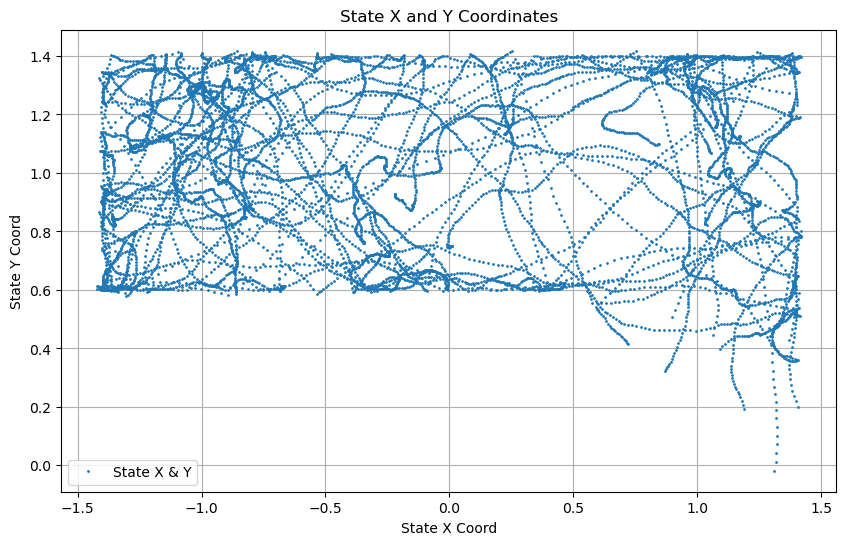

In [6]:
dataset = Offline_data_creator(normalise_data=False)
dataset.create_dataset()
big_feed, big_target = dataset.get_all_items()


# Plotting state x and state y with red dots for the filtered conditions
plt.figure(figsize=(10, 6))
plt.plot(big_feed[:,0], big_feed[:,1], 'o', markersize=1, label='State X & Y')
plt.xlabel('State X Coord')
plt.ylabel('State Y Coord')
plt.title('State X and Y Coordinates')
plt.legend()
plt.grid(True)
plt.show()

## Check uncertainty quantification by models 

### visualise training data


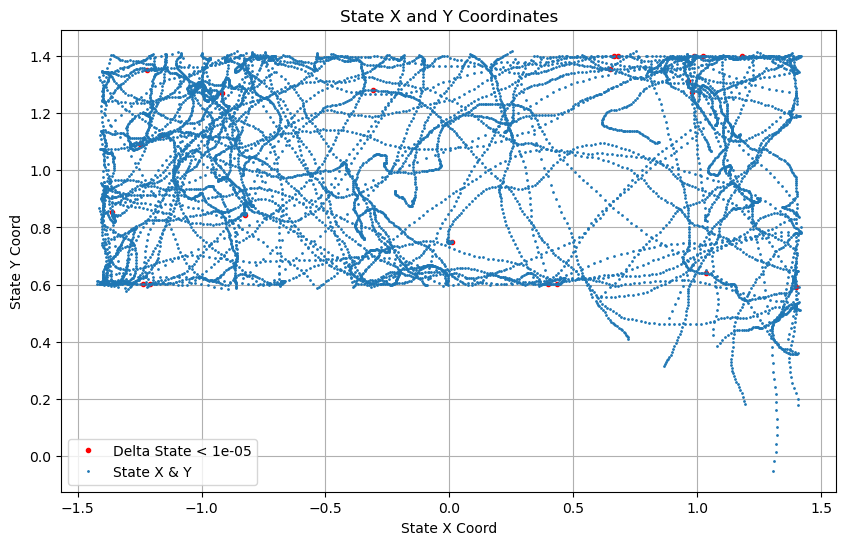

In [7]:
df = pd.read_pickle('save_files/Dataset_df.pkl') #dataset trajectories saved for for last data creation (seeded so repeats)
df
small_value_change = 0.00001

filter_condition = (df['delta_x_coord'].abs() < small_value_change) | (df['delta_y_coord'].abs() < small_value_change)
filtered_df = df[filter_condition]
len(filtered_df)

train_trajectories_array = df[['state_x_coord', 'state_y_coord', 'state_x_vel', 'state_y_vel']].values


# Plotting state x and state y with red dots for the filtered conditions
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['state_x_coord'], filtered_df['state_y_coord'], 'r.', label=f'Delta State < {small_value_change}')
plt.xlabel('State X Coord')
plt.ylabel('State Y Coord')
plt.title('State X and Y Coordinates with Small Delta States')
plt.plot(df['state_x_coord'], df['state_y_coord'], 'o', markersize= 1,  label='State X & Y')
plt.xlabel('State X Coord' )
plt.ylabel('State Y Coord')
plt.title('State X and Y Coordinates')
plt.legend()
plt.grid(True)
plt.show()


Apply dataset to the dynamics models

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DynamicsNet(nn.Module):
    def __init__(self, input_dim, output_dim, n_neurons = 512, activation = nn.ReLU):
        super(DynamicsNet, self).__init__()

        # Validate inputs
        assert input_dim > 0
        assert output_dim > 0
        assert n_neurons > 0

        # Store configuration parameters
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_neurons = n_neurons

        # Create layers for the net
        self.input_layer = nn.Linear(input_dim, n_neurons)
        self.h0 = nn.Linear(n_neurons, n_neurons)
        self.h0_act = activation()
        self.h1 = nn.Linear(n_neurons, n_neurons)
        self.h1_act = activation()
        self.output_layer = nn.Linear(n_neurons, output_dim)


    def forward(self, x):
        x = self.input_layer(x)
        x = self.h0(x)
        x = self.h0_act(x)
        x = self.h1(x)
        x = self.h1_act(x)
        x = self.output_layer(x)

        return x

class DynamicsEnsemble():
    def __init__(self, input_dim, output_dim, n_models=4, n_neurons=512, threshold=1.5, n_layers=2, activation=nn.ReLU, cuda=False):
        self.n_models = n_models

        self.threshold = threshold

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.models = []

        for i in range(n_models):
            model = DynamicsNet(input_dim, output_dim, n_neurons=n_neurons, activation=activation).to(device)
            self.models.append(model)


    def forward(self, model, x):
        return self.models[model](x)

    def train_step(self, model_idx, feed, target):
        # Reset Gradients
        self.optimizers[model_idx].zero_grad()

        # Feed forward
        next_state_pred = self.models[model_idx](feed)
        output = self.losses[model_idx](next_state_pred, target)

        # Feed backwards
        output.backward()

        # Weight update
        self.optimizers[model_idx].step()

        # Tensorboard
        return output


    def train(self, dataloader, epochs = 5, optimizer = torch.optim.Adam, loss = nn.MSELoss, summary_writer = None, comet_experiment = None):

        hyper_params = {
            "dynamics_n_models":  self.n_models,
            "usad_threshold": self.threshold,
            "dynamics_epochs" : 5
        }
        if(comet_experiment is not None):
            comet_experiment.log_parameters(hyper_params)

        # Define optimizers and loss functions
        self.optimizers = [None] * self.n_models
        self.losses = [None] * self.n_models

        for i in range(self.n_models):
            self.optimizers[i] = optimizer(self.models[i].parameters())
            self.losses[i] = loss()

        # Start training loop
        for epoch in range(epochs):
            for i, batch in enumerate(tqdm(dataloader)):
                # Split batch into input and output
                feed, target = batch

                #print('feed', feed)
                #print('target', target)
                feed, target = feed.to(device), target.to(device)


                loss_vals = list(map(lambda i: self.train_step(i, feed, target), range(self.n_models)))

                # Tensorboard
                if(summary_writer is not None):
                    for j, loss_val in enumerate(loss_vals):
                        summary_writer.add_scalar('Loss/dynamics_{}'.format(j), loss_val, epoch*len(dataloader) + i)

                if(comet_experiment is not None and i % 10 == 0):
                    for j, loss_val in enumerate(loss_vals):
                        comet_experiment.log_metric('dyn_model_{}_loss'.format(j), loss_val, epoch*len(dataloader) + i)
                        comet_experiment.log_metric('dyn_model_avg_loss'.format(j), sum(loss_vals)/len(loss_vals), epoch*len(dataloader) + i)


    def usad(self, predictions):
        # Compute the pairwise distances between all predictions
        distances = scipy.spatial.distance_matrix(predictions, predictions)

        # If maximum is greater than threshold, return true
        return (np.amax(distances) > self.threshold)

    def predict(self, x):
        # Generate prediction of next state using dynamics model
        with torch.set_grad_enabled(False):
            return torch.stack(list(map(lambda i: self.forward(i, x), range(self.n_models))))

    def save(self, save_dir):
        for i in range(self.n_models):
            torch.save(self.models[i].state_dict(), os.path.join(save_dir, "dynamics_{}.pt".format(i)))

    def load(self, load_dir):
        for i in range(self.n_models):
            self.models[i].load_state_dict(torch.load(os.path.join(load_dir, "dynamics_{}.pt".format(i))))



In [9]:
# Assuming the input dimension (4 state features + 2 action features) and output dimension (4 next state features)
input_dim = 6
output_dim = 5

# Initialize the Dynamics Ensemble
ensemble = DynamicsEnsemble(input_dim=input_dim, output_dim=output_dim, n_models=4, n_neurons=512, activation=nn.ReLU, cuda=False)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
# Assuming you want to train for 10 epochs
ensemble.train(dataloader=dataloader, epochs=10)


100%|██████████| 77/77 [00:00<00:00, 100.45it/s]


### Reviewing the P-MDP states created during dynamics-based agent planning!! (SKIP if NOT trained with policy)

rather than systematically trying to find where the models showed uncertainty which is difficult given the continuous nature of the action and observation space, we can instead collect the locations and velocities that DID come up during the trajectory generation using the dynamics models....
this will be a subset of the real systematic uncertainty quantification but a quick and easy one to check

In [10]:
filename = 'save_files/halted_locations_list_train.pkl'
with open(filename, 'rb') as file:
    # Use pickle.load() to load the object from the file
    halted_locations = pickle.load(file)
halted_locations[:3]

[[tensor([ 1.5782,  2.1418,  1.5925, -0.5930]),
  tensor([-0.0054,  2.1978,  3.7093, -0.8057]),
  tensor([-0.6544,  1.0710, -0.5233,  1.5156])],
 [tensor([ 1.3322,  1.4045, -0.0616,  0.3940]),
  tensor([ 1.8856,  2.3450,  1.7048, -1.6454]),
  tensor([ 0.9845,  2.3222, -1.4938, -0.6547])],
 [tensor([-1.3079,  1.3097, -0.2140,  1.6521]),
  tensor([1.3190, 1.9248, 3.3207, 0.4707]),
  tensor([ 1.2121,  1.2991, -0.5200, -1.8993])]]

In [11]:
#convert from list of lists to numpy array of x, y, x-vel, y-vel of where the dynamics models showed 'uncertainty' above threshold

halted_locations_array = None

for sublist in halted_locations:
    for tensor in sublist:
        # Convert tensor to numpy array
        array = tensor.numpy()
        # If big_array is None, initialize it with the first array
        if halted_locations_array is None:
            halted_locations_array = array
        else:
            # Stack the arrays vertically
            halted_locations_array = np.vstack((halted_locations_array, array))

print(halted_locations_array.shape)

(3077, 4)


In [12]:
## Depending on whether the original data is normalised, may need to renormalise this as well

#dataset.observation_mean
#dataset.observation_std
#normalised_halted = (halted_locations_array - dataset.observation_mean.values)/dataset.observation_std.values



**Now let's plot!!**
given there is both a location and velocity for the 'uncertainty, let's plot both as arrow vectors

In [30]:
def plot_maze(maze, center_x=0, center_y=0, offset_x=2, offset_y=2):
    """
    Plots the given maze using matplotlib.
    
    Parameters:
    - maze: 2D list representing the maze layout with 1s and 0s.
    - center_x, center_y: Coordinates for the center of the maze plot.
    - offset_x, offset_y: Offsets to adjust the maze position.
    """
    def index_to_plot_coord(i, j):
        """Convert maze index to plot coordinates."""
        plot_x = (j - offset_x) + center_x
        plot_y = -(i - offset_y) + center_y  # Invert y-axis for matrix to plot conversion
        return plot_x, plot_y

    # Draw lines between adjacent 1s in the maze
    for i in range(len(maze)):
        for j in range(len(maze[i])):
            if maze[i][j] == 1:
                current_x, current_y = index_to_plot_coord(i, j)
                # Check and draw line to the right
                if j + 1 < len(maze[i]) and maze[i][j + 1] == 1:
                    right_x, right_y = index_to_plot_coord(i, j + 1)
                    plt.plot([current_x, right_x], [current_y, right_y], 'k-')  # 'k-' for black line
                # Check and draw line downward
                if i + 1 < len(maze) and maze[i + 1][j] == 1:
                    down_x, down_y = index_to_plot_coord(i + 1, j)
                    plt.plot([current_x, down_x], [current_y, down_y], 'k-')

U_MAZE = [
    [1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1]
]


In [62]:

def plot_with_arrows_and_maze(train_trajectories_array, uncertain_locations_array, scale=0.1, coloured_arrows = False , lims=2.5):
    U_MAZE = [
        [1, 1, 1, 1, 1],
        [1, 0, 0, 0, 1],
        [1, 1, 1, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 1, 1, 1, 1]
    ]
    
    plot_maze(U_MAZE, center_x=0, center_y=0, offset_x=2, offset_y=2)
    
    plt.plot(train_trajectories_array[:,0], train_trajectories_array[:,1], 'o', color='lightblue', markersize=1, label='train_trajectories')
    for i in range(len(train_trajectories_array)):
        plt.arrow(train_trajectories_array[i, 0], train_trajectories_array[i, 1], 
                  scale * train_trajectories_array[i, 2], scale * train_trajectories_array[i, 3], 
                  head_width=0.02, head_length=0.02, fc='b', ec='b')

    if coloured_arrows:

        # Plot points and arrows for normalised_halted, with color based on direction
        #plt.plot(uncertain_locations_array[:,0], uncertain_locations_array[:,1], 'o', color='lightgrey', markersize=1, label='P-MDP')
        angles = np.arctan2(uncertain_locations_array[:, 3], uncertain_locations_array[:, 2])
        normalized_angles = (angles + np.pi) / (2 * np.pi)
        cmap = cm.get_cmap('hsv') 
        for i, angle in enumerate(angles):
            color = cmap(normalized_angles[i])
            plt.arrow(uncertain_locations_array[i, 0], uncertain_locations_array[i, 1], 
                    scale * uncertain_locations_array[i, 2], scale * uncertain_locations_array[i, 3], 
                    head_width=0.06, head_length=0.08, fc=color, ec=color)
    else:
        for i in range(len(uncertain_locations_array)):
            plt.arrow(uncertain_locations_array[i, 0], uncertain_locations_array[i, 1], 
                    scale * uncertain_locations_array[i, 2], scale * uncertain_locations_array[i, 3], 
                    head_width=0.02, head_length=0.02, fc='red', ec='orange')

    # Final plot adjustments
    plt.xlabel('State X Coord')
    plt.ylabel('State Y Coord')
    plt.title('State X and Y Coordinates with Velocities')
    plt.xlim(-lims,lims)
    plt.ylim(-lims, lims)
    #plt.legend()
    plt.grid(True)
    #plt.show()


In [14]:
#plot_with_arrows_and_maze(train_trajectories_array, halted_locations_array, coloured_arrows=True)
#plt.show()

**And So....**

* we can see from the plot above that the majority of the the 'uncertain' trajectories occur OUTSIDE the grid - which is good!!! It shows that the model successfully appreciates that going in that direction is NOT a good idea, as indeed it would just get stuck on the wall. 

* BUT what about the WHOLE other ARM of the U maze?? is it never queried?? Is it uncertain about it?? 

* Do the dynamics models know what they know, and know what they DON't know? How much do they NOT KNOW what they DON'T KNOW? 


**Also, why the top right corner??**
* a lot of the training data is focused on the top right.. so maybe the dynamics have learned that it should keep moving in that direction until it no longer can




### Systematically query around the training trajectories to find where dynamics models show uncertainty (Can do even without policy training!!)

- to the x-y locations in the training trajectory find the locations around each point: top, top left, left, bottom left, bottom, bottom right, right, top right
- create enhanced dataset and then run through dyamics models to see whether they show uncertainty. 
- Assume actions are set to 0, then systematically change and increase

#### Trying to be data efficient

In [15]:

def generate_squares_vectorized(trajectories, num_circles=1, initial_distance=0.1):
    num_centers = trajectories.shape[0]
    # There are 8 points per square for each circle
    num_points_per_center = 8 * num_circles
    
    # Distance increments for each circle
    distances = torch.arange(1, num_circles + 1, dtype=torch.float) * initial_distance
    
    # Direction vectors for the 8 points around a center
    directions = torch.tensor([
        [0, 1],    # Top
        [0, -1],   # Bottom
        [-1, 0],   # Left
        [1, 0],    # Right
        [-1, 1],   # Top-Left
        [1, 1],    # Top-Right
        [-1, -1],  # Bottom-Left
        [1, -1]    # Bottom-Right
    ], dtype=torch.float)
    
    all_results = []
    for distance in distances:
        for direction in directions:
            displacement = direction * distance
            # Apply displacement to the initial points (trajectories[:, 0:2])
            adjusted_points = trajectories[:, 0:2] + displacement
            # Concatenate the adjusted points with the rest of trajectories columns for each point
            concatenated = torch.cat((adjusted_points, trajectories[:, 2:]), dim=1)
            all_results.append(concatenated)
    
    # Stack all results to get a final tensor
    final_results = torch.cat(all_results, dim=0)
    
    return final_results

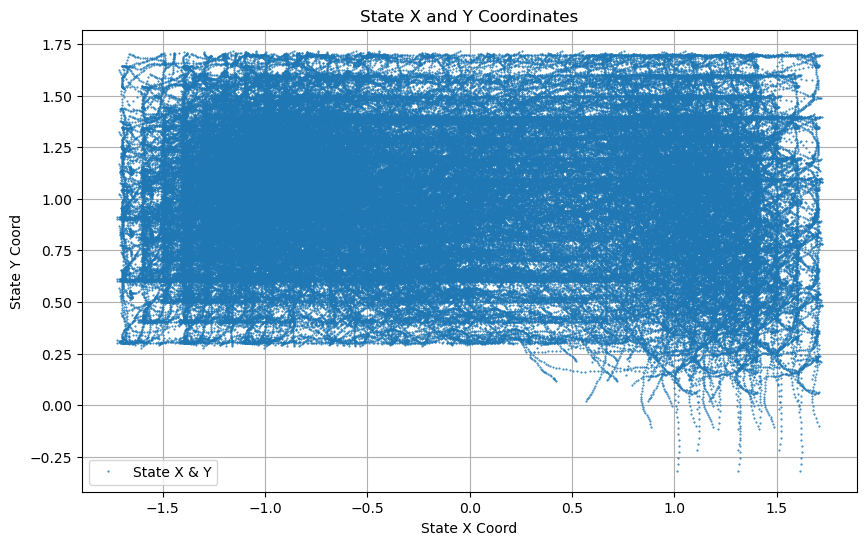

In [16]:
adjusted_feed = generate_squares_vectorized(big_feed, num_circles = 3 )


# Plotting state x and state y with red dots for the filtered conditions
plt.figure(figsize=(10, 6))
plt.plot(adjusted_feed[:,0], adjusted_feed[:,1], 'o',markersize=0.5, label='State X & Y')
plt.xlabel('State X Coord')
plt.ylabel('State Y Coord')
plt.title('State X and Y Coordinates')
plt.legend()
plt.grid(True)
plt.show()

#### Realising it's better just to be systematic

In [95]:

# Define the rectangle bounds and step size for x and y
x_start, x_end, x_step = -1.5, 1.5, 0.1
y_start, y_end, y_step = -1.5, -1.5, 0.1

# Define the bounds and step size for z1 (3rd col) and z2 (4th col)
x_vel_start, x_vel_end, z1_step = -2, 2, 0.4
y_vel_start, y_vel_end, z2_step = -2, 2, 0.4

x_action_start, x_action_end, x_action_step = -1, 1, 0.4
y_action_start, y_action_end, y_action_step = -1, 1, 0.4

# Generate the coordinates for each dimension
x_coords = np.arange(x_start, x_end + x_step, x_step)
y_coords = np.arange(y_start, y_end + y_step, y_step)
x_vel_coords = np.arange(x_vel_start, x_vel_end + z1_step, z1_step)
y_vel_coords = np.arange(y_vel_start, y_vel_end + z2_step, z2_step)
x_act_coords = np.arange(x_action_start, x_action_end, x_action_step)
y_act_coords = np.arange(y_action_start, y_action_end, y_action_step)

# Create a meshgrid for all combinations, then flatten it to get all combinations
xx, yy, zz1, zz2, ww1, ww2 = np.meshgrid(x_coords, y_coords, x_vel_coords, y_vel_coords,x_act_coords, y_act_coords, indexing='ij')
final_points = np.vstack([xx.ravel(), yy.ravel(), zz1.ravel(), zz2.ravel(), ww1.ravel(), ww2.ravel()]).T

# Show the shape of the final array and the first 10 points for a preview
print(final_points.shape)
final_points[:10]


(187550, 6)


array([[-1.5, -1.5, -2. , -2. , -1. , -1. ],
       [-1.5, -1.5, -2. , -2. , -1. , -0.6],
       [-1.5, -1.5, -2. , -2. , -1. , -0.2],
       [-1.5, -1.5, -2. , -2. , -1. ,  0.2],
       [-1.5, -1.5, -2. , -2. , -1. ,  0.6],
       [-1.5, -1.5, -2. , -2. , -0.6, -1. ],
       [-1.5, -1.5, -2. , -2. , -0.6, -0.6],
       [-1.5, -1.5, -2. , -2. , -0.6, -0.2],
       [-1.5, -1.5, -2. , -2. , -0.6,  0.2],
       [-1.5, -1.5, -2. , -2. , -0.6,  0.6]])

In [96]:
len(final_points)/62

3025.0

In [97]:
class Systematic_dataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
      
        return self.data[idx]  


batch_size = 62

my_dataset = Systematic_dataset(final_points)
data_loader = DataLoader(my_dataset, batch_size=batch_size, shuffle=False)

In [98]:
final_points.shape

(187550, 6)

In [99]:
predictions = []

with torch.no_grad():  
    for states in tqdm(data_loader):
        preds = ensemble.predict(states)  
        predictions.append(preds)

# Concatenate all predictions
all_predictions = torch.cat(predictions, dim=0)

print(all_predictions.shape)


100%|██████████| 3025/3025 [00:04<00:00, 746.00it/s]

torch.Size([12100, 62, 5])


In [100]:
all_predictions_reshaped = all_predictions.view(-1, 5).numpy()
all_predictions_reshaped = all_predictions_reshaped.reshape(-1,4,5)

In [101]:
uncertainties = []
for i in tqdm(range(all_predictions_reshaped.shape[0])):
    uncertainties.append(ensemble.usad(all_predictions_reshaped[i,:, :]))


100%|██████████| 187550/187550 [00:02<00:00, 75408.33it/s]


In [102]:
sum(uncertainties)

4

In [103]:
final_points_selected = final_points[np.where(uncertainties),:].squeeze()
final_points_selected.shape

(4, 6)

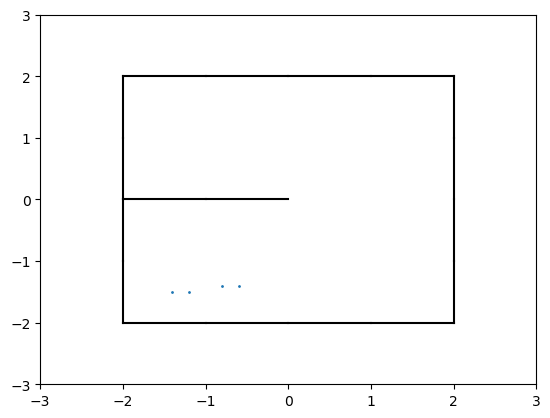

In [104]:
plt.figure()
plt.plot(final_points_selected[:,0], final_points_selected[:,1], 'o', markersize= 1)
plot_maze(U_MAZE)
plt.ylim(-3,3)
plt.xlim(-3,3)

plt.show()

/var/folders/53/d8br5nln6vq67q925j2wx6kc0000gn/T/ipykernel_14507/1356159694.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


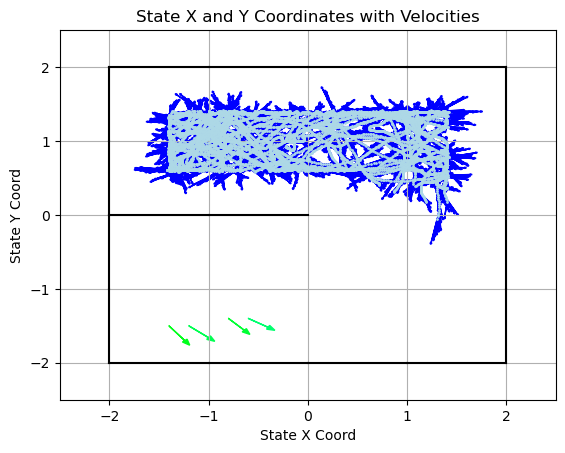

In [105]:
plot_with_arrows_and_maze(train_trajectories_array, final_points_selected, coloured_arrows=True, lims = 2.5)
plt.show()

In [ ]:
plt.hist()

## Evaluating dynamics model uncertainties in relation to evaluations!!


In [24]:
filename = '/Users/riccardoconci/Local_documents/ACS submissions/CausalRL/DeepRL_miniproject/MOReL/eval_obs.pkl'
with open(filename, 'rb') as file:
    # Use pickle.load() to load the object from the file
    eval_obs = pickle.load(file)

filename = '/Users/riccardoconci/Local_documents/ACS submissions/CausalRL/DeepRL_miniproject/MOReL/eval_actions.pkl'
with open(filename, 'rb') as file:
    # Use pickle.load() to load the object from the file
    eval_actions = pickle.load(file)

filename = '/Users/riccardoconci/Local_documents/ACS submissions/CausalRL/DeepRL_miniproject/MOReL/eval_reward_locations.pkl'
with open(filename, 'rb') as file:
    # Use pickle.load() to load the object from the file
    eval_reward_locations = pickle.load(file)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/riccardoconci/Local_documents/ACS submissions/CausalRL/DeepRL_miniproject/MOReL/eval_obs.pkl'

In [ ]:
def convert_list_of_list(list_object, from_tensor= True):
    final_array = None

    for sublist in list_object:
        for tensor in sublist:
            # Convert tensor to numpy array
            if from_tensor:
                array = tensor.numpy()
            else:
                array = tensor
            # If big_array is None, initialize it with the first array
            if final_array is None:
                final_array = array
            else:
                # Stack the arrays vertically
                final_array = np.vstack((final_array, array))
    return final_array



In [ ]:
eval_reward_locations_array = convert_list_of_list(eval_reward_locations, from_tensor=False)
eval_obs_array = convert_list_of_list(eval_obs, from_tensor=True)
eval_actions_array = convert_list_of_list(eval_actions, from_tensor=True)

In [ ]:
eval_reward_locations_array.shape
eval_actions_array.shape
eval_obs_array.shape

eval_df = pd.DataFrame({
    'x_state': eval_obs_array[:, 0],
    'y_state': eval_obs_array[:, 1],
    'x_vel': eval_obs_array[:, 2],
    'y_vel': eval_obs_array[:, 3],
    'x_action': eval_actions_array[:, 0],
    'y_action': eval_actions_array[:, 1],
    'x_reward': eval_reward_locations_array[:, 0],
    'y_reward': eval_reward_locations_array[:, 1]
})
eval_df


,x_state,y_state,x_vel,y_vel,x_action,y_action,x_reward,y_reward
0,-0.086550,-1.195401,0.000000,0.000000e+00,3.690335,6.185234,-1.04078,-0.945380
1,-0.084169,-1.193020,0.238164,2.381638e-01,3.560933,4.449016,-1.04078,-0.945380
2,-0.079411,-1.188262,0.475760,4.757605e-01,5.416515,9.186296,-1.04078,-0.945380
3,-0.072283,-1.181134,0.712791,7.127912e-01,5.058638,6.744396,-1.04078,-0.945380
4,-0.062791,-1.171642,0.949257,9.492574e-01,5.514947,6.790671,-1.04078,-0.945380
...,...,...,...,...,...,...,...,...
51195,1.398487,1.398502,0.001112,6.324884e-15,1.427481,5.049305,-1.10739,-1.008898
51196,1.398494,1.398502,0.000636,6.324884e-15,1.323266,6.126674,-1.10739,-1.008898
51197,1.398497,1.398502,0.000362,6.324884e-15,1.795709,6.668437,-1.10739,-1.008898
51198,1.398499,1.398502,0.000205,6.324884e-15,1.722274,5.644948,-1.10739,-1.008898


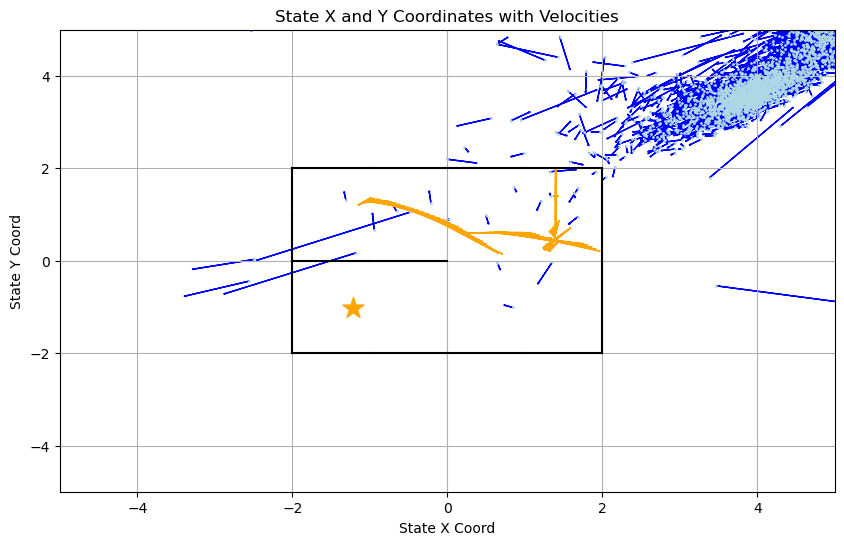

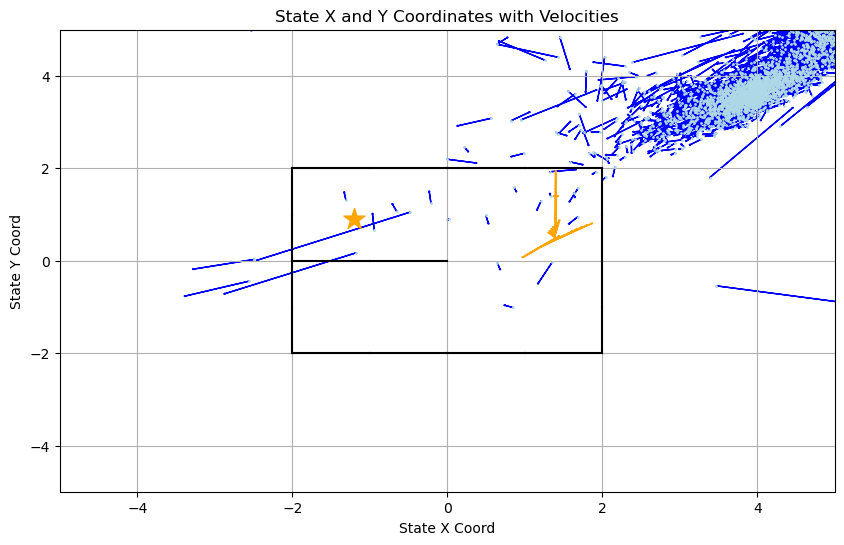

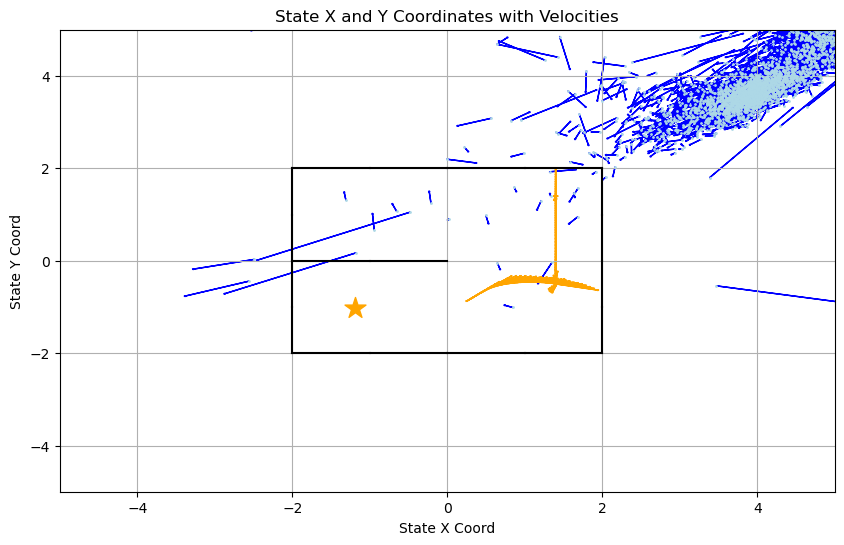

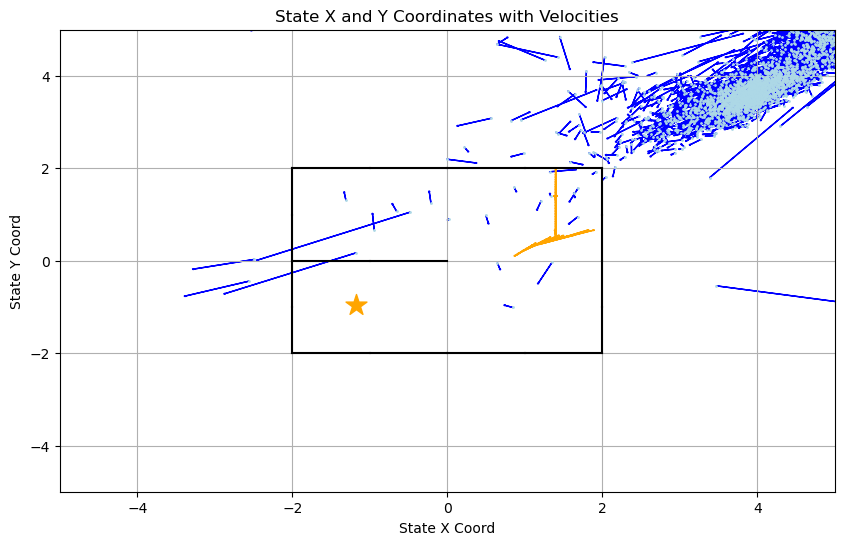

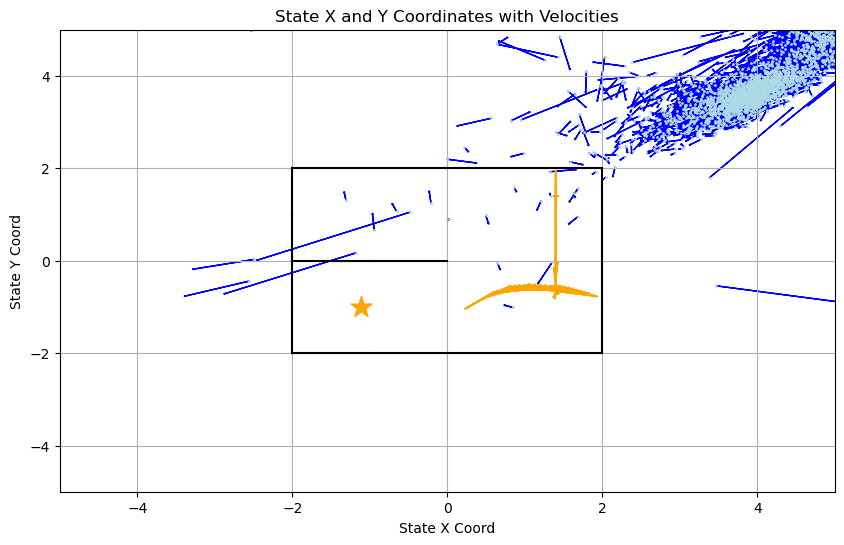

In [ ]:
for i, ((x_reward, y_reward), group) in enumerate(eval_df.groupby(['x_reward', 'y_reward'])):
    if i >= 5:  # Only process the first 5 groups
        break    
    # Assuming you want to use 'x_state', 'y_state', 'x_vel', 'y_vel' from the group as 'normalised_halted'
    val_trajectory = group[['x_state', 'y_state', 'x_vel', 'y_vel']].to_numpy()
    
    # Now, you can plot the group with the maze and arrows
    plot_with_arrows_and_maze(halted_locations_array, val_trajectory, scale=0.1)

    plt.scatter(x_reward, y_reward, color='orange', s=250, marker='*', label='Reward Location')
    
    # Final plot adjustments, if needed, before showing or moving to the next plot
    #plt.legend()
    plt.show()




## Other little helps

In [ ]:
import gymnasium as gym
env = gym.make('PointMaze_UMaze-v3')

observation_dim = env.observation_space['observation']
print(f"Observation space dimensions: {observation_dim.shape[0]}")

if isinstance(env.action_space, gym.spaces.Discrete):
    action_dim = env.action_space.n
    print(f"Action space dimensions (Discrete): {action_dim}")
elif isinstance(env.action_space, gym.spaces.Box):
    action_dim = env.action_space.shape
    print(f"Action space dimensions (Box): {action_dim}")
else:
    print("Action space type is not recognized.")


Observation space dimensions: 4
Action space dimensions (Box): (2,)


In [ ]:

action = env.action_space.sample()
state = env.reset()
next_state, reward, terminated, truncated, info = env.step(action)
state

({'observation': array([0.12916109, 0.84025685, 0.        , 0.        ]),
  'achieved_goal': array([0.12916109, 0.84025685]),
  'desired_goal': array([0.89706   , 1.18631887])},
 {'success': False})

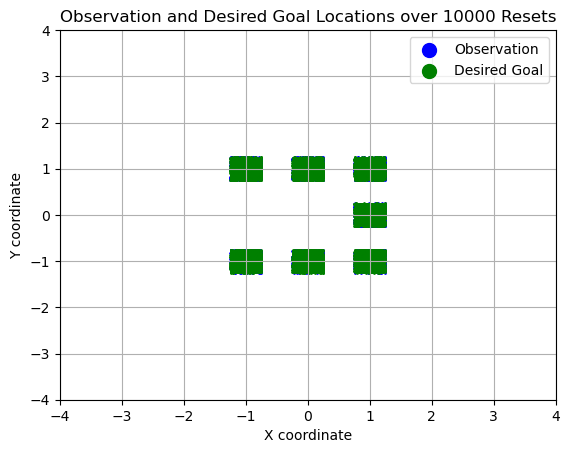

In [ ]:
env = gymnasium.make('PointMaze_UMaze-v3')

observation_xs = []
observation_ys = []
desired_goal_xs = []
desired_goal_ys = []

for _ in range(10000):
    state = env.reset()
    observation_xs.append(state[0]['observation'][0])
    observation_ys.append(state[0]['observation'][1])
    desired_goal_xs.append(state[0]['desired_goal'][0])
    desired_goal_ys.append(state[0]['desired_goal'][1])

# Plotting
plt.scatter(observation_xs, observation_ys, c='blue', label='Observation', s=1)
plt.scatter(desired_goal_xs, desired_goal_ys, c='green', label='Desired Goal', s=1)
plt.title("Observation and Desired Goal Locations over 10000 Resets")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.legend(markerscale=10)
plt.grid(True)
plt.show()

# DQN
### PLOTTING BO CORRELATION for DQN

In [ ]:
import seaborn as sns
def plot_symmetric_pairwise_correlation_heatmap(df, part='full', save_as_pdf=True, filename='DQN_BO.pdf'):
    """
    Plot a symmetric pairwise correlation heatmap for the DataFrame columns.
    The colormap is adjusted so that grey represents a correlation of 0.
    Manually drawn light grey grid lines are added between heatmap cells.
    Optionally saves the plot as a PDF.

    :param df: The DataFrame containing the data.
    :param part: String, if 'lower', shows the lower triangular part;
                 if 'upper', shows the upper triangular part;
                 if 'full', shows the full heatmap.
    :param save_as_pdf: Boolean, if True, saves the plot as a PDF.
    :param filename: String, the name of the file to save the plot to.
    """
    # Calculate the symmetric pairwise correlation matrix
    correlation_matrix = df.corr()

    # Creating a mask for the upper or lower triangle
    mask = np.zeros_like(correlation_matrix, dtype=bool)

    if part == 'lower':
        mask[np.triu_indices_from(mask)] = True
    elif part == 'upper':
        mask[np.tril_indices_from(mask)] = True

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f", square=True, mask=mask)

    # Draw grid lines manually
    n_rows, n_cols = correlation_matrix.shape
    for i in range(1, n_rows):
        ax.axhline(i, color='lightgrey', lw=0.5)
        ax.axvline(i, color='lightgrey', lw=0.5)

    plt.title("Pairwise Correlations between Parameters and Metrics")
    plt.xticks(rotation=65, ha='right')

    # Save the plot as a PDF file
    if save_as_pdf:
        plt.savefig(filename, format='pdf', bbox_inches='tight')

    plt.show()

# Example usage
# plot_symmetric_pairwise_correlation_heatmap(df, part='full', save_as_pdf=True, filename='my_heatmap.pdf')


In [ ]:
file_path = '/Users/riccardoconci/Downloads/DQN_BO.csv'
df = pd.read_csv(file_path)



In [ ]:
df.columns

Index(['Name', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime', 'Sweep',
       'batch_size', 'buffer_size', 'exploration_fraction', 'learning_rate',
       'tau', 'total_timesteps', 'charts/SPS', 'charts/episodic_length',
       'charts/episodic_return', 'final_global_step', 'global_step',
       'losses/q_values', 'losses/td_loss'],
      dtype='object')

In [ ]:
df = df[['batch_size', 'buffer_size', 'exploration_fraction','learning_rate', 'tau','final_global_step' ]]

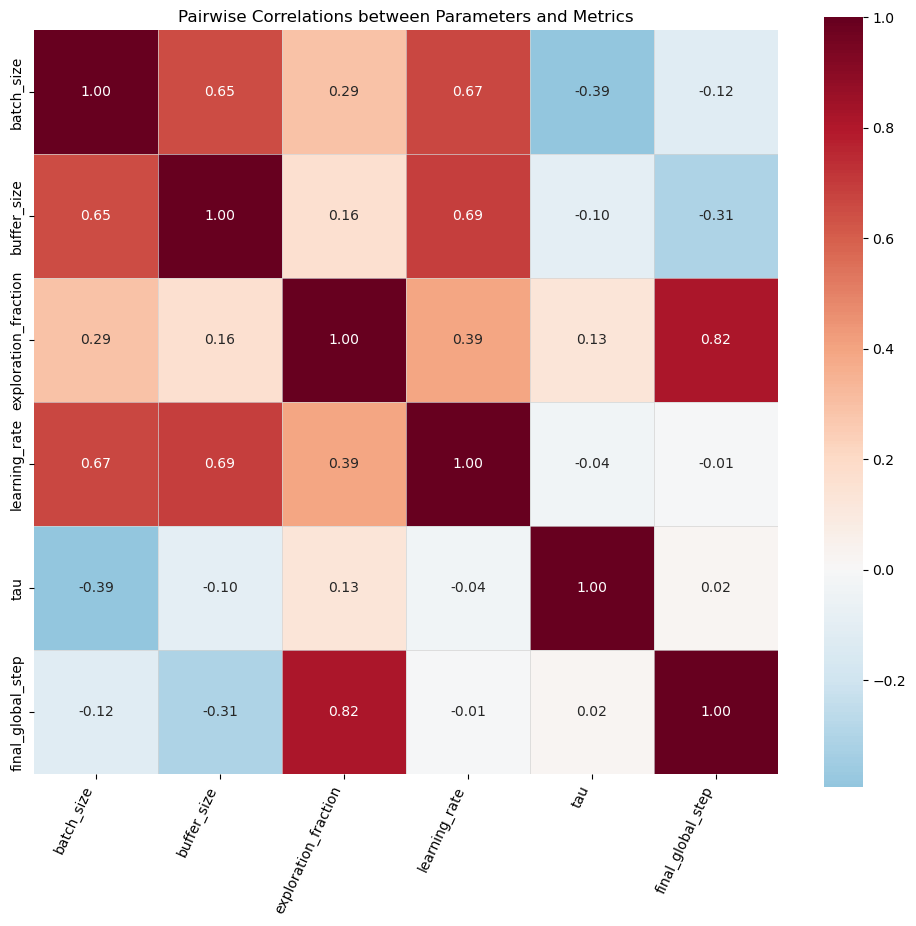

In [ ]:
plot_symmetric_pairwise_correlation_heatmap(df, 'full')